# Fakenews detection
Karolina Mączka, Tymoteusz Urban

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from wordcloud import WordCloud
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\karim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df=pd.read_csv('PreProcessedData.csv', header=0, sep=',')

In [3]:
# porządek
df = df[['title', 'text', 'Ground Label']]
df.rename(columns={'Ground Label': 'label'}, inplace=True)
df.head()

,title,text,label
0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


## Train test split

In [4]:
# Rozdzielamy zbiory do trenowania i testowania
X_rest, X_test, y_rest, y_test = train_test_split(df[['title', 'text']], df['label'], test_size=0.30, random_state=42)

In [5]:
y_rest.value_counts()

fake    29459
true    18872
Name: label, dtype: int64

In [6]:
X_train, X_validate, y_train, y_validate = train_test_split(X_rest, y_rest, test_size=0.30, random_state=42)

In [7]:
print(y_train.value_counts())
print(y_validate.value_counts())

fake    20645
true    13186
Name: label, dtype: int64
fake    8814
true    5686
Name: label, dtype: int64


stosunek ilości fake do true wszędzie jest taki sam, więc możemy przyjąć że jest to dobre rozdzielenie danych

In [8]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train_df.to_csv('training_data.csv', index=False)

In [9]:
testing_df = pd.concat([X_test, y_test], axis=1)
testing_df.to_csv('testing_data.csv', index=False)

In [10]:
# zapisanie ramki do walidacji
validate_df = pd.concat([X_validate, y_validate], axis=1)
validate_df.to_csv('fakenws_validation.csv', index=False)
validate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14500 entries, 55024 to 57779
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   14368 non-null  object
 1   text    14486 non-null  object
 2   label   14500 non-null  object
dtypes: object(3)
memory usage: 453.1+ KB


In [11]:
df2 = pd.concat([X_train, y_train], axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33831 entries, 17623 to 8544
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   33497 non-null  object
 1   text    33800 non-null  object
 2   label   33831 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


## Getting to know the data

In [12]:
df2.head()

,title,text,label
17623,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
61073,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,fake
8102,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,Nathan Domingo is the founder of Identity Eur...,fake
67016,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,"When it comes to limiting our free speech, not...",fake
67779,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,Little Miss Sunshine has fooled a lot of peo...,fake


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33831 entries, 17623 to 8544
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   33497 non-null  object
 1   text    33800 non-null  object
 2   label   33831 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB




## Data Preprocessing

### Encoding

In [15]:
# zamina fake i true na wartości numeryczne
df2.loc[df2["label"] == "fake","label"] = 0
df2.loc[df2["label"] == "true","label"] = 1

In [16]:
# before pipeline function
def encodeLabels(df):
    df.loc[df["label"] == "fake","label"] = 0
    df.loc[df["label"] == "true","label"] = 1
    return df

### NaNs

In [17]:
# Jest bardzo mało nulli więc możemy się ich pozbyć
df2.dropna(inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33466 entries, 17623 to 8544
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   33466 non-null  object
 1   text    33466 non-null  object
 2   label   33466 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [64]:
# transformer function
def handleNa(df):
    df.dropna(inplace=True)
    print('NaNs deleted')
    return df

### Combine columns

Z racji, że będziemy analizować same słowa, łączymy kolumny title i tekst - dla naszego modelu nie będzie miało znaczenia z której kolumny pochodzą

In [19]:
df2.loc[8102]

title    THE GUY WHO Punched “Moldylocks” Speaks Out Ab...
text     Nathan Domingo is the founder of  Identity Eur...
label                                                    0
Name: 8102, dtype: object

In [20]:
df2['text'] = df2[['title', 'text']].apply(" ".join, axis=1)

In [21]:
df2.loc[8102]['text']

'THE GUY WHO Punched “Moldylocks” Speaks Out About Violent Antifa Female With A Bottle [VIDEO] Nathan Domingo is the founder of  Identity Europa  and is the guy who was seen by millions of viewers punching a female Antifa thug the media tried to portray as a helpless woman that just happened to be in the area when fighting broke out at a free speech rally in Berkeley, CA on April 16th.The last time these two group clashed, the Trump supporters were seriously outnumbered. This time was a different story. Trump supporters came prepared for the unprovoked attacks of these hate groups and took them to task. With all the violence that happened yesterday, leftist media outlets seemed to be obsessed with reporting on the video that was taken of an alleged Trump supporter who punched an antifa female who was part of the violent group  Oak Roots Collective  that traveled to Berkeley to confront Trump supporters and shut down their right to free speech.Here s the video. At the 18 second mark you

In [22]:
df2 = df2.drop(columns='title')

In [23]:
df2.head()

,text,label
17623,In the Western World Respect for Law No Longer...,0
61073,"WATCH: President Obama Unleashes On Trump, Sa...",0
8102,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,0
67016,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,0
67779,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,0


In [65]:
# transformer function
def combineColumns(df):
    df['text'] = df[['title', 'text']].apply(" ".join, axis=1)
    df = df.drop(columns='title')
    print('Columns combined')
    return df

### Outliers

(array([3.3058e+04, 3.3800e+02, 4.4000e+01, 1.4000e+01, 2.0000e+00,
        1.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.90000e+01, 1.43610e+04, 2.87030e+04, 4.30450e+04, 5.73870e+04,
        7.17290e+04, 8.60710e+04, 1.00413e+05, 1.14755e+05, 1.29097e+05,
        1.43439e+05]),
 <BarContainer object of 10 artists>)

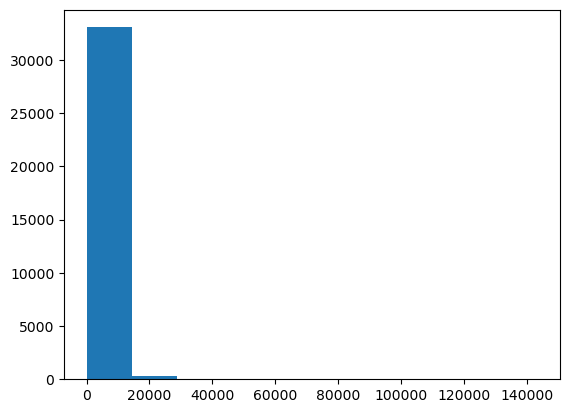

In [25]:
df2['textlength'] = df2['text'].apply(len)
plt.hist(df2['textlength'])

In [26]:
print(df2[(df2['textlength'] > 40000)].count())
df2[(df2['textlength'] > 40000)].head()

text          32
label         32
textlength    32
dtype: int64


,text,label,textlength
12641,Re: Why Are So Many People Choosing To Leave T...,0,115924
63859,Re: Why Is Obama Threatening Russia With World...,0,97429
21862,Benny Morris’s Untenable Denial of the Ethnic ...,0,92823
58778,President-Elect Donald Trump's First Televised...,0,41697
18039,Re: The Velocity Of Money In The U.S. Falls To...,0,43623


In [27]:
# Wyrzucamy bardzo dlugie teksty (ponad 40000 znaków)
df2 = df2[(df2['textlength'] < 40000)]
df2.drop(columns='textlength')

,text,label
17623,In the Western World Respect for Law No Longer...,0
61073,"WATCH: President Obama Unleashes On Trump, Sa...",0
8102,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,0
67016,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,0
67779,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,0
...,...,...
59264,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,0
57858,Russia denies its planes killed civilians in S...,1
63057,Hungary’s “Wall” Versus the U.S. “Wall” Op-Ed ...,0
61429,Pastor Caught Trump’s Spiritual Advisor Steal...,0


In [77]:
#transformer function
def removeOutliers(df):
    df['textlength'] = df['text'].apply(len)
    df = df[df['textlength'] < 40000]
    df = df.drop(columns='textlength')
    print('Outliers removed')
    return df

### Removing stopwords

In [29]:
#stopword removal
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def remove_stopwords(s):
    s = [lemmatizer.lemmatize(word.lower()) for word in s if not word.lower() in stop]
    return s

In [30]:
#punctuation and number removal
def remove_punctuations(s):
    s = re.sub(r'[^a-zA-Z\s]', '', s)
    return s

In [31]:
df2['text'] = df2['text'].apply(remove_punctuations)
df2['text'] = df2['text'].apply(word_tokenize)

In [32]:
df2['text'] = df2['text'].apply(remove_stopwords)

In [33]:
def list2string(text):
    text = " ".join(wrd for wrd in text)
    return text

In [34]:
df3 = df2.copy()

In [35]:
df3["text"] = df3["text"].apply(list2string)
df3.head()

,text,label,textlength
17623,western world respect law longer exists wester...,0,390
61073,watch president obama unleashes trump say terr...,0,1682
8102,guy punched moldylocks speaks violent antifa f...,0,2176
67016,say amazon tell customer forced federal govern...,0,1568
67779,antigun zealot katie couric hit million defama...,0,4688


In [67]:
# transformer function
def removeStopwords(df):
    df['text'] = df['text'].apply(remove_punctuations)
    print('Punctuation removed')
    df['text'] = df['text'].apply(word_tokenize)
    print('Words tokenized')
    df['text'] = df['text'].apply(remove_stopwords)
    print('Stopwords removed')
    df['text'] = df['text'].apply(list2string)
    return df

### Extracting english

In [37]:
def deleteUrl(text):
    return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

In [39]:
# usuwamy linki
df3['text'] = df3['text'].apply(deleteUrl)

In [40]:
# tworzymy krótszą kolumnę do analizy języka
def shortenText(text):
    return text[:60]

In [41]:
df3['shorttext'] = df3['text'].apply(shortenText)

In [42]:
df3[df3['shorttext'].apply(len) < 10]

,text,label,textlength,shorttext
37561,,0,0,
43017,,0,0,
66646,pravdaru,0,8,pravdaru
21689,,0,0,
7105,pravdaru,0,8,pravdaru
27895,nbc news,0,8,nbc news
44231,,0,0,
8855,,0,0,
22129,,0,0,
7977,,0,0,


In [43]:
# usuwamy teksty które mają mniej niż 10 znaków - były to same linki
df3 = df3[df3['shorttext'].apply(len) > 10]

In [44]:
df3.head()

,text,label,textlength,shorttext
17623,western world respect law longer exists wester...,0,276,western world respect law longer exists wester...
61073,watch president obama unleashes trump say terr...,0,1078,watch president obama unleashes trump say terr...
8102,guy punched moldylocks speaks violent antifa f...,0,1366,guy punched moldylocks speaks violent antifa f...
67016,say amazon tell customer forced federal govern...,0,1023,say amazon tell customer forced federal govern...
67779,antigun zealot katie couric hit million defama...,0,3328,antigun zealot katie couric hit million defama...


In [120]:
df4 = df3.copy()

In [121]:
DetectorFactory.seed = 0
df4['lang'] = df4['shorttext'].apply(detect)

In [122]:
# robimy model który będzie wykrywał po angielsku
df4 = df4[df4['lang']=='en']

In [123]:
df4 = df4[['text', 'label']].reset_index(drop=True)
df4

,text,label
0,western world respect law longer exists wester...,0
1,watch president obama unleashes trump say terr...,0
2,guy punched moldylocks speaks violent antifa f...,0
3,say amazon tell customer forced federal govern...,0
4,trump crisis lewd remark woman come light new ...,1
...,...,...
29065,trump give brutal warning lawless sanctuary ci...,0
29066,state attorney lied baltimore police probable ...,0
29067,hungary wall versus u wall oped catherine j fr...,0
29068,pastor caught trump spiritual advisor stealing...,0


In [68]:
#transformer function
def dropLanguages(df):
    DetectorFactory.seed = 0
    df['text'] = df['text'].apply(deleteUrl)
    df['shorttext'] = df['text'].apply(shortenText)
    df = df[df['shorttext'].apply(len) > 10]
    print('Text cleaned')
    df['lang'] = df['shorttext'].apply(detect)
    df = df[df['lang']=='en']
    df = df.drop(columns=['shorttext', 'lang'])
    print('Languages dropped')
    return df

In [50]:
# żeby zapisać dane
df4.to_csv('train_data.csv', index=False)

### Word Cloud

In [51]:
df_fake = df4[df4["label"] == 0]
df_true = df4[df4["label"] == 1]

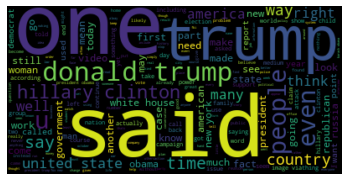

In [155]:
# Fałszywe
consolidated_f = ' '.join(
    word for word in df_fake['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_f)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

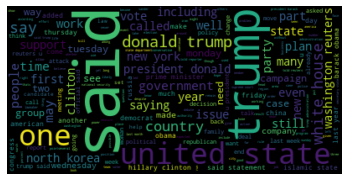

In [156]:
# Prawdziwe
consolidated_t = ' '.join(
    word for word in df_true['text'].astype(str))
wordcloud = WordCloud().generate(consolidated_t)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [2]:
#df4 = pd.read_csv('train_data.csv')

In [57]:
# Bag of words - liczba wystąpień każdego słowa w danym tekście
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df4['text'])

In [ ]:
#Transformer function
def myCountVectorizer(df):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(df['text'])

In [58]:
# Zamiana częstości w częstotliwość wystąpień
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [59]:
X_train_tfidf.shape

(29118, 178407)

## Pipeline

In [109]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

na_transformer = FunctionTransformer(handleNa)
column_transformer = FunctionTransformer(combineColumns)
outliers_transformer = FunctionTransformer(removeOutliers)
stopwords_transformer = FunctionTransformer(removeStopwords)
language_transformer = FunctionTransformer(dropLanguages)

custom_pipe = Pipeline([
    ("na", na_transformer),
    ('columns', column_transformer),
    ('outliers', outliers_transformer),
    ("stopwords", stopwords_transformer),
    ("language", language_transformer),
])

model_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

In [110]:
train = pd.read_csv('training_data.csv', index_col=False)

In [111]:
train

,title,text,label
0,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
1,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,fake
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,Nathan Domingo is the founder of Identity Eur...,fake
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,"When it comes to limiting our free speech, not...",fake
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,Little Miss Sunshine has fooled a lot of peo...,fake
...,...,...,...
33826,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,Marilyn Mosby held a press conference today in...,fake
33827,Russia denies its planes killed civilians in S...,MOSCOW (Reuters) - Russia s Defence Ministry d...,true
33828,Hungary’s “Wall” Versus the U.S. “Wall”,Op-Ed by Catherine J. Frompovich\r\nCurrently ...,fake
33829,Pastor Caught Trump’s Spiritual Advisor Steal...,It seems that Donald Trump s spiritual advisor...,fake


In [112]:
train = encodeLabels(train)

In [115]:
train_transformed = custom_pipe.transform(train)

NaNs deleted
Columns combined
Outliers removed
Punct removed
Words tokenized
Stopwords removed
Text cleaned
Languages dropped


C:\Users\tymek\AppData\Local\Temp\ipykernel_2952\2669187233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lang'] = df['shorttext'].apply(detect)


In [116]:
train_transformed

,text,label
0,western world respect law longer exists wester...,0
1,watch president obama unleashes trump say terr...,0
2,guy punched moldylocks speaks violent antifa f...,0
3,say amazon tell customer forced federal govern...,0
5,trump crisis lewd remark woman come light new ...,1
...,...,...
33825,trump give brutal warning lawless sanctuary ci...,0
33826,state attorney lied baltimore police probable ...,0
33828,hungary wall versus u wall oped catherine j fr...,0
33829,pastor caught trump spiritual advisor stealing...,0


In [117]:
train_transformed_x = train_transformed['text']
train_transformed_y = train_transformed['label']

In [118]:
train_xx = model_pipe.fit_transform(train_transformed_x, train_transformed_y)

In [119]:
train_xx.shape

(29070, 178186)